In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder
from utils.class_weights import get_normalized_class_weights
from utils.model_evaluate import ModelEvaluator

# Carregamento dos dados

In [2]:
df = pd.read_csv('../data/02_handling_outliers/data.csv')
print(df.shape)

df.head()

(22742, 14)


,user,sexo,uf,idade,dias,pviews,visitas,tempo_total,device,blog_cartola,cartola_status,horas_engajamento_futebol,horas_engajamento_outros_esportes,horas_engajamento_home
0,1919933,NaN,NaN,NaN,1,1,1,0.012500,m_only,0.012500,cartola_free,0.000000,0.000000,0.000000
1,1979452,NaN,NaN,NaN,7,66,10,1.018757,pc_e_m,0.068122,cartola_pro,0.911605,0.000000,0.026530
2,1987950,NaN,NaN,NaN,7,14,6,1.293761,pc_e_m,0.012500,cartola_free,0.000000,0.564663,0.025642
3,1988149,NaN,NaN,NaN,8,49,24,1.995802,pc_only,0.013103,cartola_free,0.357694,0.961152,0.651353
4,1996199,NaN,NaN,NaN,21,75,46,2.845341,pc_e_m,0.026424,cartola_free,0.335683,1.996365,0.219123


Atribuindo labels ao target

In [3]:
df.loc[df['cartola_status'] == 'cartola_free', 'target_cartola_status'] = 0
df.loc[df['cartola_status'] == 'cartola_pro', 'target_cartola_status'] = 1
df.drop(columns=['cartola_status'], inplace=True)

# Preparação dos dados

## Correlação e Feature Engineering

Analisando distribuição do target

In [4]:
df['target_cartola_status'].value_counts(normalize=True) * 100

target_cartola_status
0.0    97.388093
1.0     2.611907
Name: proportion, dtype: float64

Vamos utilizar a correlação de Spearman, pois ela captura relações monotônicas (não apenas lineares) e é mais robusta a outliers

<Axes: >

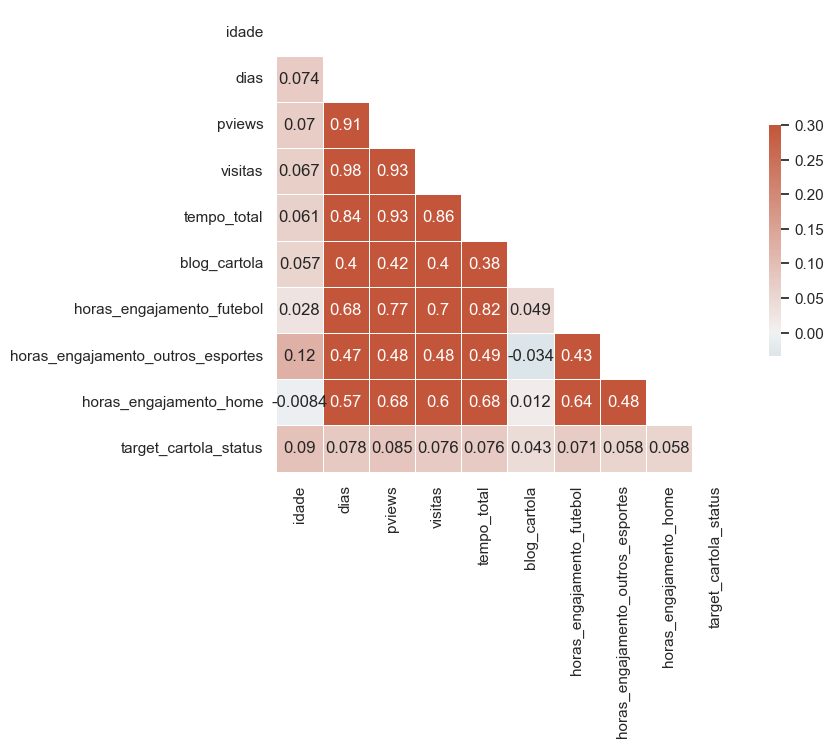

In [5]:
sns.set_theme(style="white")

corr = df.drop(columns=['user']).corr('spearman', numeric_only=True)
mask = np.triu(np.ones_like(corr, dtype=bool))

f, ax = plt.subplots(figsize=(8, 6))

cmap = sns.diverging_palette(230, 20, as_cmap=True)

sns.heatmap(corr
            , mask=mask
            , cmap=cmap
            , vmax=.3
            , center=0
            , square=True
            , linewidths=.5
            , cbar_kws={"shrink": .5}
            , annot=True)

Temos muitas features altamente correlatas, vamos reduzir algumas para evitar possível multicolinearidade

In [6]:
# taxa de engajamento
df['taxa_engajamento'] = df['tempo_total'] / df['visitas']

# razão entre a qtd de pviews por visitas
df['pviews_por_visitas'] = df['pviews'] / df['visitas']

# frequencia de visitas
df['frequencia_visitas'] = df['visitas'] / df['dias']

Dropando colunas que não serão mais utilizadas

- coluna UF: Como vimos na análise exploratória, se não há diferença significativa na distribuição de clientes PRO e Free, a variável adiciona ruído sem valor preditivo
Também vamos evitar o problema de criar muitas variáveis dummy.
- coluna devices: vamos retirá-la, pois seu número de missings representa 50% do dataframe, o que pode comprometer a análise, até mesmo na hora de preenchê-los.
- coluna sexo: vimos na análise exploratória que o sexo masculino é predominante, e tbm notamos o alto nível de missing. Nessa primeira etapa, vou retirar essa variável,
  porém, vale a pena testa-la de outras formas futuramente, como por exemplo, imputar os valores nulos com um valor numérico (ex: -1) ou uma categoria representativa ('nao_atribuido').


In [441]:
drop_cols = ['pviews', 'visitas', 'dias', 'tempo_total', 'uf', 'sexo', 'device']
# drop_cols = ['uf', 'device']

df = df.drop(columns=drop_cols)

KeyError: "['pviews', 'visitas', 'dias', 'tempo_total', 'uf', 'sexo', 'device'] not found in axis"

<Axes: >

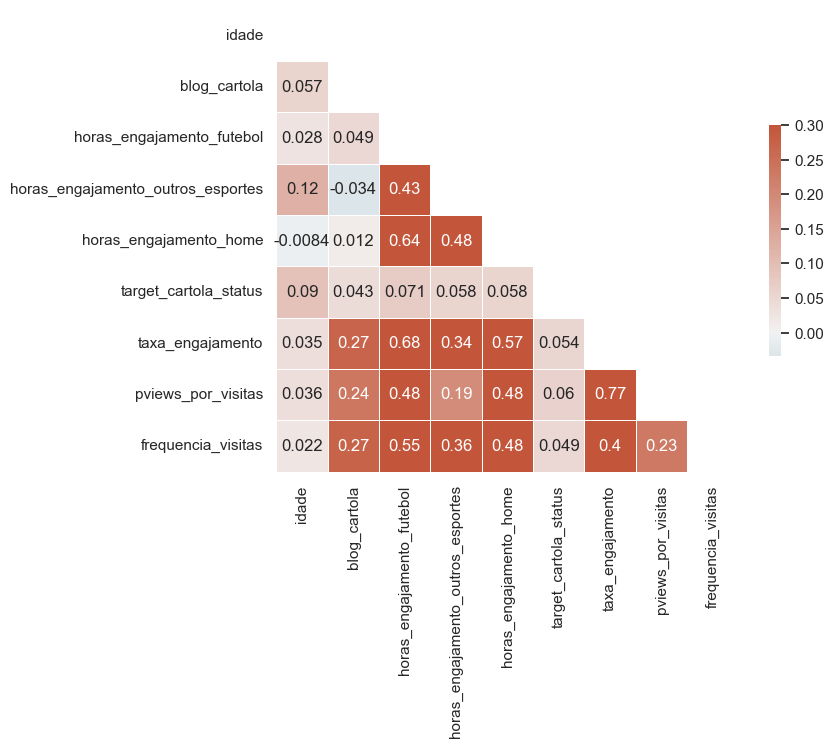

In [10]:
sns.set_theme(style="white")

corr = df.drop(columns=['user']).corr('spearman', numeric_only=True)
mask = np.triu(np.ones_like(corr, dtype=bool))

f, ax = plt.subplots(figsize=(8, 6))

cmap = sns.diverging_palette(230, 20, as_cmap=True)

sns.heatmap(corr
            , mask=mask
            , cmap=cmap
            , vmax=.3
            , center=0
            , square=True
            , linewidths=.5
            , cbar_kws={"shrink": .5}
            , annot=True)

Houve uma boa redução na correlação das variáveis.

## Split em treino, validação e teste

In [11]:
df_test = df.sample(frac=.2, random_state=42) # separando 20% para teste

df_train_val = df.drop(df_test.index)

In [12]:
df_train_val.columns

Index(['user', 'idade', 'blog_cartola', 'horas_engajamento_futebol',
       'horas_engajamento_outros_esportes', 'horas_engajamento_home',
       'target_cartola_status', 'taxa_engajamento', 'pviews_por_visitas',
       'frequencia_visitas'],
      dtype='object')

In [13]:
X = df_train_val.drop(columns=['user', 'target_cartola_status'])
y = df_train_val['target_cartola_status']

In [14]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

## Column Transformer

In [15]:
# Define as colunas para cada tipo de transformação
cols_num = [
    'idade',
    'taxa_engajamento',
    'pviews_por_visitas',
    'frequencia_visitas',
    'blog_cartola',
    'horas_engajamento_futebol',
    'horas_engajamento_outros_esportes',
    'horas_engajamento_home',
]


# Pipeline para variáveis numéricas
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),  # Primeiro trata missing
    ('scaler', StandardScaler())                    # Depois faz a padronização
])

# Pipeline para variáveis categóricas
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),  # Primeiro trata missing
    ('onehot', OneHotEncoder(drop='first', sparse_output=False))            # Depois faz o encoding
])


# Cria o preprocessador completo usando ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, cols_num),
        # ('cat', categorical_transformer, cols_cat),
    ],
    remainder='passthrough'
)

preprocessor

ColumnTransformer(remainder='passthrough',
                  transformers=[('num',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('scaler', StandardScaler())]),
                                 ['idade', 'taxa_engajamento',
                                  'pviews_por_visitas', 'frequencia_visitas',
                                  'blog_cartola', 'horas_engajamento_futebol',
                                  'horas_engajamento_outros_esportes',
                                  'horas_engajamento_home'])])

Para avaliar o resultado da saída do pré-processamento, basta descomentar as linhas abaixo:

In [16]:
# # treinando
# df_test_preprocessor = X_val.head().copy()
# preprocessor.fit_transform(X_train)

# # transformação
# test_preprocessor_transformed = preprocessor.transform(df_test_preprocessor)

# df_test_preprocessor_transformed = pd.DataFrame(
#     data=test_preprocessor_transformed,
#     columns=preprocessor.get_feature_names_out()  # Ajuste conforme seu pipeline
# )

# display(df_test_preprocessor)
# display(df_test_preprocessor_transformed)

# Experimentos

In [457]:
from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.metrics import make_scorer, precision_score, recall_score, f1_score, roc_auc_score, precision_recall_curve, auc
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier

import optuna

In [462]:
def plot_precision_recall_curve(y_true: np.ndarray, y_pred: np.ndarray, title: str = 'Precision-Recall Curve') -> None:
    """
    Plots the precision-recall curve for a binary classification model.

    Parameters:
        y_true (numpy.ndarray): True binary labels.
        y_pred (numpy.ndarray): Predicted probabilities or confidence scores for positive class.
        title (str, optional): Title for the plot. Defaults to 'Precision-Recall Curve'.

    Returns:
        None
    """
    precision, recall, thresholds = precision_recall_curve(y_true, y_pred)
    auc_score = auc(recall, precision)

    plt.plot(recall, precision, label=f'Precision-Recall curve (AUC = {auc_score:.2f})')
    plt.axvline(x=recall[1], linestyle='dashed')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title(title + f' | best: {recall[1]}')
    plt.legend(loc="lower left")
    plt.show()

In [107]:
# Calcula os pesos para os dados de treino
class_weights = get_normalized_class_weights(y_train)
class_weights

{np.float64(0.0): np.float64(0.513041945717307),
 np.float64(1.0): np.float64(19.66891891891892)}

In [448]:
# calculando o scale pos weights
scale_pos_weight = int(class_weights[1] / class_weights[0])
scale_pos_weight

38

In [447]:
# simples função para chamar o Model Evaluator
def fit_evaluate(model, X_train, y_train, X_val, y_val, th=0.5):
    model.fit(X_train, y_train);

    train_results = ModelEvaluator(model, X_train, y_train, th=th)
    display(train_results.evaluate())

    # Avaliação no conjunto de validação
    val_results = ModelEvaluator(model, X_val, y_val, th=th)
    display(val_results.evaluate())

## Logistic Regression

In [226]:
lr_model = Pipeline([
            ('preprocessor', preprocessor),
            ('classifier', LogisticRegression(
                class_weight=class_weights, 
                max_iter=2000, 
                random_state=42
            ))
        ])

fit_evaluate(lr_model, X_train=X_train, y_train=y_train, X_val=X_val, y_val=y_val)

,AUC,PRECISION,RECALL,LOGLOSS,F1,ACCURACY
0,64.4,5.1,55.95,993.77,9.35,72.43


,AUC,PRECISION,RECALL,LOGLOSS,F1,ACCURACY
0,63.63,5.64,54.72,1008.31,10.23,72.03


In [232]:
lr_model = Pipeline([
            ('preprocessor', preprocessor),
            ('classifier', LogisticRegression(
                class_weight=class_weights, 
                max_iter=2000, 
                random_state=42
            ))
        ])

fit_evaluate(lr_model, X_train=X_train, y_train=y_train, X_val=X_val, y_val=y_val, th=0.45)

,AUC,PRECISION,RECALL,LOGLOSS,F1,ACCURACY
0,66.02,4.68,68.38,1305.55,8.76,63.78


,AUC,PRECISION,RECALL,LOGLOSS,F1,ACCURACY
0,64.42,5.06,66.04,1337.15,9.4,62.9


## Decision Trees

In [257]:
dt_model = Pipeline([
            ('preprocessor', preprocessor),
            ('classifier', DecisionTreeClassifier(
                max_depth=5,
                class_weight=class_weights, 
                random_state=42
            ))
        ])

fit_evaluate(dt_model, X_train=X_train, y_train=y_train, X_val=X_val, y_val=y_val)

,AUC,PRECISION,RECALL,LOGLOSS,F1,ACCURACY
0,71.73,5.65,77.03,1200.05,10.52,66.71


,AUC,PRECISION,RECALL,LOGLOSS,F1,ACCURACY
0,60.08,4.49,55.66,1288.62,8.32,64.25


In [262]:
dt_model = Pipeline([
            ('preprocessor', preprocessor),
            ('classifier', DecisionTreeClassifier(
                max_depth=5,
                class_weight=class_weights, 
                random_state=42
            ))
        ])

fit_evaluate(dt_model, X_train=X_train, y_train=y_train, X_val=X_val, y_val=y_val, th=0.45)

,AUC,PRECISION,RECALL,LOGLOSS,F1,ACCURACY
0,71.0,4.72,88.65,1649.02,8.97,54.25


,AUC,PRECISION,RECALL,LOGLOSS,F1,ACCURACY
0,59.18,3.97,66.98,1736.32,7.49,51.83


## RandomForest

In [265]:
rf_model = Pipeline([
            ('preprocessor', preprocessor),
            ('classifier', RandomForestClassifier(
                max_depth=5,
                class_weight=class_weights, 
                random_state=42
            ))
        ])

fit_evaluate(rf_model, X_train=X_train, y_train=y_train, X_val=X_val, y_val=y_val, th=0.5)

,AUC,PRECISION,RECALL,LOGLOSS,F1,ACCURACY
0,73.75,7.4,70.54,836.02,13.39,76.81


,AUC,PRECISION,RECALL,LOGLOSS,F1,ACCURACY
0,62.41,5.73,49.06,901.34,10.26,74.99


In [300]:
rf_model = Pipeline([
            ('preprocessor', preprocessor),
            ('classifier', RandomForestClassifier(
                max_depth=5,
                class_weight=class_weights, 
                random_state=42
            ))
        ])

fit_evaluate(rf_model, X_train=X_train, y_train=y_train, X_val=X_val, y_val=y_val, th=0.45)

,AUC,PRECISION,RECALL,LOGLOSS,F1,ACCURACY
0,74.48,6.21,80.81,1136.16,11.53,68.48


,AUC,PRECISION,RECALL,LOGLOSS,F1,ACCURACY
0,66.49,5.65,66.04,1192.54,10.42,66.91


Random forest por enquanto está obtendo os melhores resultados, com o mínimo de mudança nos hiperparâmetros

## XGboost

In [356]:
xgb_model = Pipeline([
            ('preprocessor', preprocessor),
            ('classifier', XGBClassifier(
                # max_depth=6,
                objective='binary:logistic',
                eval_metric='logloss',
                scale_pos_weight=scale_pos_weight,
                random_state=42
            ))
        ])
fit_evaluate(xgb_model, X_train=X_train, y_train=y_train, X_val=X_val, y_val=y_val, th=0.5)

,AUC,PRECISION,RECALL,LOGLOSS,F1,ACCURACY
0,97.79,63.65,97.03,53.49,76.87,98.52


,AUC,PRECISION,RECALL,LOGLOSS,F1,ACCURACY
0,52.26,6.96,7.55,203.05,7.24,94.37


## LGBM

In [357]:
lgbm_model = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', LGBMClassifier(
        # max_depth=5,
        scale_pos_weight=scale_pos_weight,
        objective='binary',
        metric='binary_logloss',
        random_state=42
    ))
])
fit_evaluate(lgbm_model, X_train=X_train, y_train=y_train, X_val=X_val, y_val=y_val, th=0.5)

,AUC,PRECISION,RECALL,LOGLOSS,F1,ACCURACY
0,95.72,32.22,96.76,189.44,48.35,94.74


,AUC,PRECISION,RECALL,LOGLOSS,F1,ACCURACY
0,53.5,5.3,15.09,372.42,7.84,89.67


## Tunando Modelos com Optuna

### Random Forest

Vamos tunar inicialmente com um modelo mais simples

In [360]:
import warnings
warnings.filterwarnings('ignore')

In [375]:
def objective(trial):
    # 1. Suggest values for the hyperparameters using a trial object.
    classifier_name = trial.suggest_categorical('classifier', ['LogisticRegression', 'RandomForest'])
    
    if classifier_name == 'LogisticRegression':
        lr_c = trial.suggest_loguniform('logreg_c', 1e-5, 1e2)  # Sugere um valor para C
        
        classifier_obj = Pipeline([
            ('preprocessor', preprocessor),
            ('classifier', LogisticRegression(C=lr_c, class_weight=class_weights))
        ])
        
    else:
        rf_max_depth = trial.suggest_int('rf_max_depth', 5, 15)  # Intervalo sem log
        rf_n_estimators = trial.suggest_int('rf_n_estimators', 10, 100)  # Sugestão para n_estimators
        classifier_obj = Pipeline([
            ('preprocessor', preprocessor),
            ('classifier', RandomForestClassifier(max_depth=rf_max_depth, n_estimators=rf_n_estimators, class_weight=class_weights))
        ])
    
    # 2. Treine o modelo com os dados de treino
    classifier_obj.fit(X_train, y_train)
    
    # 3. Faça previsões e calcule o f1_score
    predictions = classifier_obj.predict(X_val)
    metric = f1_score(y_val, predictions)  # Alterado para usar f1_score
    
    return metric

# 4. Crie um objeto de estudo e otimize a função objetivo.
study = optuna.create_study(direction='maximize')
study.optimize(objective, timeout=300)


[I 2024-10-28 12:22:24,654] A new study created in memory with name: no-name-08513263-be79-4127-9451-fd446956bd68
[I 2024-10-28 12:22:24,702] Trial 0 finished with value: 0.10229276895943562 and parameters: {'classifier': 'LogisticRegression', 'logreg_c': 67.78721311106449}. Best is trial 0 with value: 0.10229276895943562.
[I 2024-10-28 12:22:24,911] Trial 1 finished with value: 0.06763285024154589 and parameters: {'classifier': 'RandomForest', 'rf_max_depth': 12, 'rf_n_estimators': 15}. Best is trial 0 with value: 0.10229276895943562.
[I 2024-10-28 12:22:24,939] Trial 2 finished with value: 0.09580838323353294 and parameters: {'classifier': 'LogisticRegression', 'logreg_c': 1.0134329851206832e-05}. Best is trial 0 with value: 0.10229276895943562.
[I 2024-10-28 12:22:25,665] Trial 3 finished with value: 0.0273972602739726 and parameters: {'classifier': 'RandomForest', 'rf_max_depth': 13, 'rf_n_estimators': 56}. Best is trial 0 with value: 0.10229276895943562.
[I 2024-10-28 12:22:25,695

In [376]:
study.best_params

{'classifier': 'RandomForest', 'rf_max_depth': 5, 'rf_n_estimators': 96}

In [397]:
rf_model = Pipeline([
            ('preprocessor', preprocessor),
            ('classifier', RandomForestClassifier(
                max_depth=5,
                class_weight=class_weights, 
                random_state=42,
                n_estimators=96
            ))
        ])

fit_evaluate(rf_model, X_train=X_train, y_train=y_train, X_val=X_val, y_val=y_val, th=0.5)

,AUC,PRECISION,RECALL,LOGLOSS,F1,ACCURACY
0,73.76,7.4,70.54,835.53,13.4,76.82


,AUC,PRECISION,RECALL,LOGLOSS,F1,ACCURACY
0,62.89,5.83,50.0,900.35,10.44,75.02


In [408]:
rf_model = Pipeline([
            ('preprocessor', preprocessor),
            ('classifier', RandomForestClassifier(
                max_depth=5,
                class_weight=class_weights, 
                random_state=42,
                n_estimators=96
            ))
        ])

rf_model.fit(X_train, y_train)
rf_eval = ModelEvaluator(rf_model, X_val, y_val, th=0.4)
rf_eval.evaluate()

,AUC,PRECISION,RECALL,LOGLOSS,F1,ACCURACY
0,65.32,4.89,73.58,1530.3,9.17,57.54


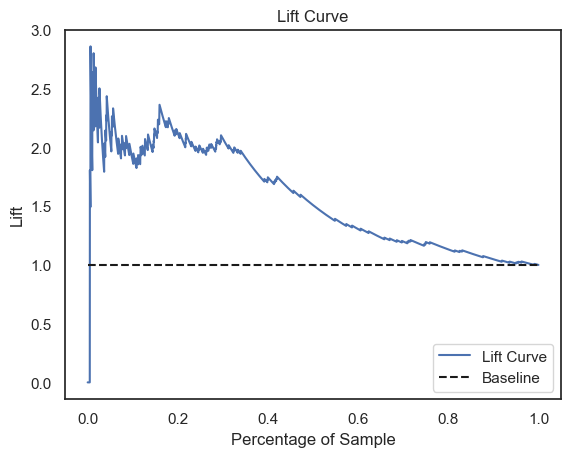

In [409]:
rf_eval.plot_lift()

rf_eval.plot_confusion_matrix(normalize='true')

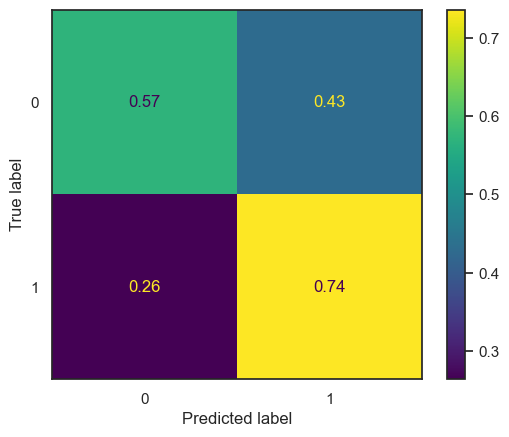

In [412]:
rf_eval.plot_confusion_matrix(normalize='true')

In [422]:
th = 0.48
y_probas = rf_model.predict_proba(X_val)[:, 1]
ypred = (y_probas > th).astype(int)

<Axes: ylabel='Count'>

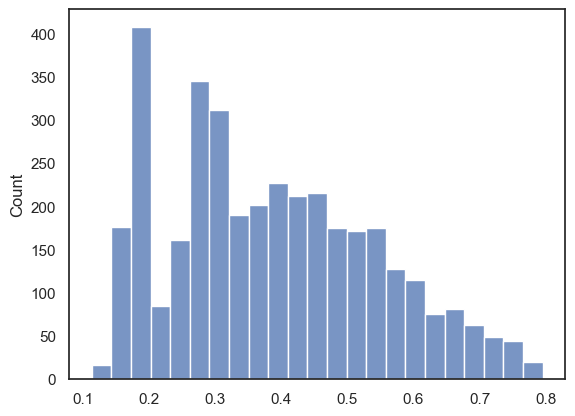

In [423]:
import seaborn as sns
sns.histplot(x=y_probas)

### XGBoost

O próximo passo é testar com um modelo mais robusto

In [449]:
scale_pos_weight

38

In [439]:
def objective(trial):
    params = {
        'objective': 'binary:logistic',  # ou 'multi:softmax' para múltiplas classes
        'eval_metric': 'logloss',        # Métrica de avaliação
        'eta': trial.suggest_float('eta', 0.01, 0.3),  # Taxa de aprendizado
        'max_depth': trial.suggest_int('max_depth', 5, 15),  # Profundidade máxima da árvore
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),  # Fração de amostras
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.5),
        'n_estimators': trial.suggest_int('n_estimators', 200, 1500),
        'n_jobs': -1,  # Usar todos os núcleos
        'scale_pos_weight': trial.suggest_int('scale_pos_weight', 38, 40),
        'random_state': 42
    }
    
    classifier_obj = Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', xgb.XGBClassifier(**params))
    ])
    
    
    # 2. Treine o modelo com os dados de treino
    classifier_obj.fit(X_train, y_train)
    
    # 3. Faça previsões e calcule a métrica
    predictions = classifier_obj.predict(X_val)
    metric = recall_score(y_val, predictions)
    
    return metric

# 4. Crie um objeto de estudo e otimize a função objetivo.
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=250)

[I 2024-10-28 13:01:16,095] A new study created in memory with name: no-name-6fd16479-f5b5-4e1b-bfc3-8a1637109e53
[I 2024-10-28 13:01:16,568] Trial 0 finished with value: 0.14150943396226415 and parameters: {'eta': 0.042714026413858484, 'max_depth': 5, 'subsample': 0.6507353514114893, 'learning_rate': 0.058308359413336695, 'n_estimators': 386, 'scale_pos_weight': 40}. Best is trial 0 with value: 0.14150943396226415.
[I 2024-10-28 13:01:18,181] Trial 1 finished with value: 0.018867924528301886 and parameters: {'eta': 0.22832956882828276, 'max_depth': 11, 'subsample': 0.7116234258616201, 'learning_rate': 0.42945967807147767, 'n_estimators': 1115, 'scale_pos_weight': 39}. Best is trial 0 with value: 0.14150943396226415.
[I 2024-10-28 13:01:20,776] Trial 2 finished with value: 0.0 and parameters: {'eta': 0.20562295786566862, 'max_depth': 7, 'subsample': 0.6923040020428491, 'learning_rate': 0.1957530324117401, 'n_estimators': 1357, 'scale_pos_weight': 39}. Best is trial 0 with value: 0.1415

In [450]:
study.best_params

{'eta': 0.04769409406169523,
 'max_depth': 5,
 'subsample': 0.9949393655069952,
 'learning_rate': 0.0025158412731914083,
 'n_estimators': 228,
 'scale_pos_weight': 40}

In [452]:
xgb_model = Pipeline([
            ('preprocessor', preprocessor),
            ('classifier', XGBClassifier(
                **study.best_params,
                random_state=42,
            ))
        ])

xgb_model.fit(X_train, y_train)
xgb_eval = ModelEvaluator(xgb_model, X_val, y_val, th=0.5)
xgb_eval.evaluate()

,AUC,PRECISION,RECALL,LOGLOSS,F1,ACCURACY
0,62.62,4.8,62.26,1335.17,8.92,62.96


In [483]:
# usando o valor da precision-recall curve
xgb_model.fit(X_train, y_train)
xgb_eval = ModelEvaluator(xgb_model, X_val, y_val, th=0.48)
xgb_eval.evaluate()

,AUC,PRECISION,RECALL,LOGLOSS,F1,ACCURACY
0,61.57,4.48,64.15,1472.85,8.38,59.14


In [498]:
th = 0.48
y_probas = xgb_model.predict_proba(X_val)[:, 1]
ypred = (y_probas > th).astype(int)

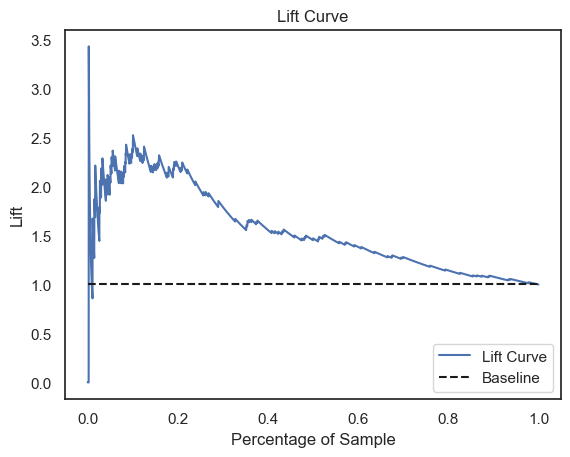

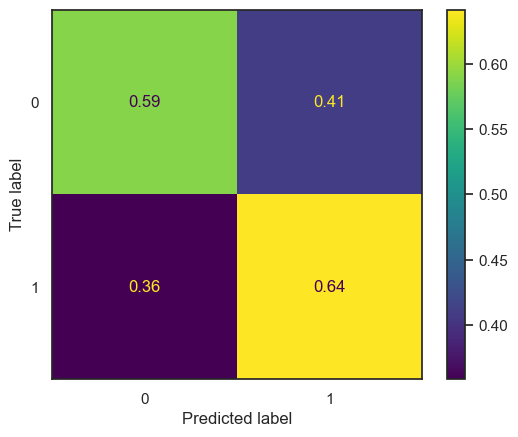

In [499]:
xgb_eval.plot_lift()

xgb_eval.plot_confusion_matrix(normalize='true')

<Axes: ylabel='Count'>

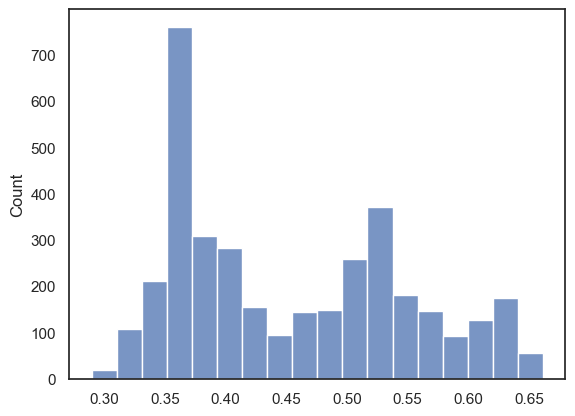

In [500]:
import seaborn as sns
sns.histplot(x=y_probas)

Precision: dos clientes que previmos como PRO, quantos realmente são

Recall: dos clientes que realmente são PRO, quantos conseguimos identificar

F1 : Bom para avaliar o trade-off entre falsos positivos e falsos negativos. Dá mais peso para a classe minoritária (PRO)

Lift

Mostra quantas vezes seu modelo é melhor que uma seleção aleatória
Muito útil para problemas de negócio como este


Vamos analisar o significado de cada métrica no contexto do Cartola FC para tomar essa decisão:

**Precision (Precisão)**
- Dos clientes que o modelo previu como potenciais PRO, quantos realmente se tornaram PRO
- Alta precision significa menos desperdício de recursos em ações de marketing
- Fórmula: Verdadeiros Positivos / (Verdadeiros Positivos + Falsos Positivos)

**Recall (Revocação/Sensibilidade)**
- Dos clientes que realmente se tornaram PRO, quantos conseguimos identificar
- Alto recall significa capturar a maior quantidade possível de clientes potenciais
- Fórmula: Verdadeiros Positivos / (Verdadeiros Positivos + Falsos Negativos)

Para o Cartola FC, eu recomendaria **priorizar Recall** pelos seguintes motivos:

1. **Modelo de Negócio**
   - Cliente PRO gera receita recorrente
   - Perder um potencial cliente PRO (falso negativo) significa perder receita garantida
   - O custo de abordar um cliente free que não se converte (falso positivo) é relativamente baixo

2. **Estratégia de Marketing**
   - Melhor abordar mais clientes potenciais, mesmo que alguns não convertam
   - O custo de comunicação/campanha provavelmente é baixo (emails, notificações no app)
   - Você pode criar diferentes níveis de ações baseado no score de propensão

3. **Competitividade do Mercado**
   - Se um cliente com alto potencial não é abordado, ele pode:
     - Continuar como free indefinidamente
     - Migrar para concorrentes
     - Perder interesse no produto

4. **Aprendizado do Negócio**
   - Alto recall permite entender melhor o comportamento dos diferentes perfis
   - Ajuda a refinar futuras campanhas e o próprio modelo

Recomendações práticas:

1. Use threshold mais baixo na classificação para aumentar o recall
2. Monitore o lift nas diferentes faixas de score
3. Crie níveis de ações diferentes baseado no score:
   - Top 10%: ação mais agressiva
   - 10-30%: ação moderada
   - 30-50%: ação leve

Você concorda com essa análise? Tem alguma informação adicional sobre o custo de aquisição ou valor do cliente PRO que devemos considerar?